# Competitors

30 June, 2024

@roman

Code to find neighbors of a given competitor for each property.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from tqdm import tqdm
import h3
import os

from scipy.spatial import KDTree
import scipy.sparse as sp
from scipy import io
from sklearn.cluster import MiniBatchKMeans, SpectralClustering, HDBSCAN
from INEGIpy import MarcoGeoestadistico

In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)
geo_framework = MarcoGeoestadistico()

---
# Data

## Properties

In [3]:
# read parquet
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s4.parquet")

# to geopandas
gdf_properties = gpd.GeoDataFrame(
    gdf_properties,
    geometry=gpd.points_from_xy(gdf_properties['longitud'], gdf_properties['latitud']),
    crs="EPSG:4326"
    )

# change crs to 6372
gdf_properties = gdf_properties.to_crs("EPSG:6372")

gdf_properties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 852931 entries, 0 to 853032
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   property_id                    852931 non-null  object        
 1   valor_fisico_construccion      852931 non-null  float64       
 2   id_avaluo                      852931 non-null  object        
 3   fecha_avaluo                   852931 non-null  datetime64[ns]
 4   colonia                        852931 non-null  object        
 5   id_clase_inmueble              852931 non-null  int64         
 6   id_tipo_inmueble               852931 non-null  int64         
 7   conservacion                   852931 non-null  float64       
 8   elevador                       824560 non-null  float64       
 9   niveles                        852931 non-null  int64         
 10  cve_ref_proximidad_urbana      852931 non-null  int64         
 1

## Cities

In [4]:
# read parquet
gdf_cities = gpd.read_parquet("../../data/misc/polygons_cities_analysis.parquet")

# change crs to 6372
gdf_cities = gdf_cities.to_crs("EPSG:6372")

gdf_cities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   city_cluster  158 non-null    int64   
 1   geometry      158 non-null    geometry
 2   id_entidad_f  158 non-null    object  
 3   id_municipio  158 non-null    object  
dtypes: geometry(1), int64(1), object(2)
memory usage: 5.1+ KB


In [5]:
# buffer 1m around the cities to include the properties that are in the border
gdf_cities['geometry'] = gdf_cities.buffer(1)

In [6]:
# see table
gdf_cities.head()

,city_cluster,geometry,id_entidad_f,id_municipio
0,0,"POLYGON ((2802509.221 807490.857, 2802509.124 ...",09,003
1,1,"POLYGON ((1629955.411 1907388.013, 1629955.308...",26,030
2,2,"POLYGON ((3774584.759 1040368.498, 3774584.666...",31,050
3,3,"POLYGON ((1689809.905 1228250.719, 1689809.802...",03,008
4,4,"POLYGON ((2925744.611 1137556.825, 2925744.525...",28,003


## Wrangle

In [7]:
# wrangle
gdf_properties = (
    gdf_properties
    # new vars
    .assign(
        property_type=lambda x: np.where(x['id_tipo_inmueble'].le(3), 'house', 'apartment'),
        longitude=lambda x: x["geometry"].x,
        latitude=lambda x: x["geometry"].y,
        estacionamiento=lambda x: x["estacionamiento"].fillna(0),
        price_per_sqm=lambda x: x["valor_mercado"] / x["superficie_vendible"],
        log_price_per_sqm=lambda x: np.log(x["price_per_sqm"]),
    )
    # drop obs
    .query("recamaras.gt(0) & banos.gt(0)")
    .reset_index(drop=True)
    # categorize variables for comparisson
    .assign(
        recamaras_cat=lambda x: np.select(
            [
                x["recamaras"].le(1),
                x["recamaras"].le(2),
                x["recamaras"].le(3),
                x["recamaras"].gt(3),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        banos_cat=lambda x: np.select(
            [
                x["banos"].le(1),
                x["banos"].le(2),
                x["banos"].le(3),
                x["banos"].gt(3),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        niveles_cat=lambda x: 
            np.where(x['niveles'].le(1), 1, 2),
        vida_util_cat=lambda x: np.select(
            [
                x["vida_util_remanente"].le(30),
                x["vida_util_remanente"].le(60),
                x["vida_util_remanente"].le(70),
                x["vida_util_remanente"].gt(70),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        elevador_cat=lambda x: 
            np.where(x['elevador'].lt(1), 0, 1),
        estacionamiento_cat=lambda x: np.select(
            [
                x["estacionamiento"].le(0),
                x["estacionamiento"].le(1),
                x["estacionamiento"].le(2),
                x["estacionamiento"].gt(2),
            ],
            [
                0, 1, 2, 3
            ],
            default=0
        ),
    )
)   

In [8]:
# get area of each city
gdf_cities["area_city_km2"] = gdf_cities["geometry"].area / 1e+6
gdf_cities.head()

,city_cluster,geometry,id_entidad_f,id_municipio,area_city_km2
0,0,"POLYGON ((2802509.221 807490.857, 2802509.124 ...",09,003,2904.067758
1,1,"POLYGON ((1629955.411 1907388.013, 1629955.308...",26,030,209.597369
2,2,"POLYGON ((3774584.759 1040368.498, 3774584.666...",31,050,421.999965
3,3,"POLYGON ((1689809.905 1228250.719, 1689809.802...",03,008,51.848444
4,4,"POLYGON ((2925744.611 1137556.825, 2925744.525...",28,003,189.096787


In [9]:
# join data
gdf_properties = (
    gdf_properties
    .sjoin(
        gdf_cities.loc[:, ["city_cluster", "geometry", 'area_city_km2']],
        how="left",
    )
    .drop_duplicates(subset=["property_id"], keep="first")
    .drop(columns=["index_right"])
    .reset_index(drop=True)
)

# see shape
gdf_properties.shape

(852913, 55)

## Mini EDA

In [10]:
# see cat vars description
(
    gdf_properties
    .filter(like="_cat")
    .apply(pd.Series.value_counts)
)

,recamaras_cat,banos_cat,niveles_cat,vida_util_cat,elevador_cat,estacionamiento_cat
0,NaN,NaN,NaN,NaN,169201.0,104011.0
1,49373.0,574747.0,462047.0,14153.0,683712.0,566704.0
2,507904.0,199792.0,390866.0,565843.0,NaN,169031.0
3,262386.0,55115.0,NaN,232567.0,NaN,13167.0
4,33250.0,23259.0,NaN,40350.0,NaN,NaN


In [11]:
# see how many properties didnt join
gdf_properties["city_cluster"].isna().sum()

0

In [12]:
# if there is a index repeated
gdf_properties.index.duplicated().sum()

0

---
# Get Competitors

## S1: Calculate

In [13]:
# functions
def get_neighbors_properties(gdf, r=1):
    # copy
    gdf = gdf.copy()

    # fit kdtree
    kdtree = KDTree(
        data=gdf[['longitude', 'latitude']],
    )

    # get neighbors at r-km
    return kdtree.query_ball_point(
        gdf[['longitude', 'latitude']],
        r=r * 1_000,
        workers=-1
    )

def get_possible_neighbors(df_own, df_theirs, vars_list):
    return (
        df_own
        .loc[:, vars_list + ['neighbors_list']]
        .explode('neighbors_list')
        .rename(columns={'neighbors_list': 'id_neighbor'})
        .reset_index()
        .merge(
            (
                df_theirs
                .assign(index=lambda x: x.index)
                .loc[:, ['index'] + vars_list]
                ),
            how='inner',
            left_on='id_neighbor',
            right_on='index',
            suffixes=('_own', '_neighbor'),
        )
        .query("property_id_own != property_id_neighbor")  # remove self
    )


# get distance
def find_competitors(gdf):
    # Distance
    gdf_distance = (
        gdf.copy()
        .assign(
            # geo distance
            geo_distance=lambda x: np.sqrt(np.sqrt(
                (x['longitude_own'] - x['longitude_neighbor'])**2
                + (x['latitude_own'] - x['latitude_neighbor'])**2
            ) / 1e+3),  # normalize to 0-1
            # topology distance
            terrain_distance=lambda x: np.abs(1-x['superficie_terreno_neighbor'] / x['superficie_terreno_own']).clip(0, 1),
            built_distance=lambda x: np.sqrt(np.abs(1-x['superficie_construida_neighbor'] / x['superficie_construida_own']).clip(0, 1)),
            # characteristics distance
            characteristics_distance=lambda x: np.sqrt(np.sqrt(
                (x['elevador_cat_own'] - x['elevador_cat_neighbor'])**2  # 0s & 1s
                + (x['niveles_cat_own'] - x['niveles_cat_neighbor'])**2  # 1s & 2s (idem)
                + (x['vida_util_cat_own'] - x['vida_util_cat_neighbor'])**2  
                + (x['recamaras_cat_own'] - x['recamaras_cat_neighbor'])**2
                + (x['banos_cat_own'] - x['banos_cat_neighbor'])**2
                + (x['estacionamiento_cat_own'] - x['estacionamiento_cat_neighbor'])**2
            ) / (0.5 * np.sqrt(1 + 1 + 3**2 + 3**2 + 3**2 + 3**2))),
            # time distance (relu)
            time_distance_raw=lambda x: (
               (x['fecha_avaluo_own'] - x['fecha_avaluo_neighbor']).dt.days
            ),
            time_distance=lambda x: np.square(x['time_distance_raw'] * (x['time_distance_raw'] > 0) / 365),  # normalize to 0-1 up to a year
        )
        # filter out those that are more than a year apart
        .query("time_distance.le(1)")
        .assign(
            # total distance
            total_distance=lambda x: (
                x['geo_distance'] * GEO_WEIGHT
                + x['terrain_distance'] * TERRAIN_WEIGHT
                + x['built_distance'] * BUILT_WEIGHT
                + x['characteristics_distance'] * CHAR_WEIGHT
                + x['time_distance'] * TIME_WEIGHT
            )
        )
        # filter all those that are above 1 of distance
        # .query("total_distance.lt(1)")
        .query("total_distance.gt(0)")  # eliminate 0s in the distance to avoid comparing to itself
    )
    # Aggregation
    df_comps = (
        gdf_distance
        .assign(
            index_distance_tuple=lambda x: list(zip(x['property_id_neighbor'], x['total_distance'])),
        )
        .groupby('property_id_own', as_index=False)
        .agg(
            neighbors_list=('index_distance_tuple', list),
            num_neighbors=('property_id_neighbor', 'count'),
        )
    )
    return df_comps


# function to orchestrate the process
def get_competitors(gdf, property_type='apartment', city=0, batch_size=None):
    # params
    cols_to_stay = [
        # variables to stay
        'property_id',
        # geographic
        'longitude', 'latitude',
        # topology
        'superficie_terreno', 'superficie_construida',
        # characteristics
        'elevador_cat', 'niveles_cat', 'vida_util_cat', 
        'recamaras_cat', 'banos_cat', 'estacionamiento_cat',
        # time
        'fecha_avaluo',
    ]

    # subset 
    gdf_work = (
        gdf
        .query("city_cluster.eq(@city) & property_type.eq(@property_type)")
        .copy()
    )

    # check if there are properties
    if gdf_work.shape[0] == 0:
        return pd.DataFrame()

    # get neighbors
    gdf_work['neighbors_list'] = get_neighbors_properties(gdf_work, r=1)

    # get possible neighbors by batch
    n_batches = gdf_work.shape[0] // batch_size
    if n_batches > 0:
        batch_indexes = np.array_split(gdf_work.index, gdf_work.shape[0] // batch_size)
    else:
        batch_indexes = [gdf_work.index]

    gdf_neighbors_list = []
    for batch in batch_indexes:
        # print batch
        # get possible neighbors
        gdf_neighbors_info = get_possible_neighbors(
            df_own=gdf_work.loc[batch],
            df_theirs=gdf_work,
            vars_list=cols_to_stay
        )
        # find competitors
        gdf_neighbors_subset = find_competitors(gdf_neighbors_info)
        # append
        gdf_neighbors_list.append(gdf_neighbors_subset)

    # concatenate
    gdf_neighbors = pd.concat(gdf_neighbors_list)
    
    return gdf_neighbors

In [14]:
# Get competitors
# city values
cities_list = gdf_properties['city_cluster'].sort_values().unique()
property_types_list = gdf_properties['property_type'].unique()

# params
GEO_WEIGHT = 0.1
TERRAIN_WEIGHT = 0.1
BUILT_WEIGHT = 0.35
CHAR_WEIGHT = 0.25
TIME_WEIGHT = 0.2

# calculate
df_competitors_list = []
for city in tqdm(cities_list, desc="Cities", position=0):
    for property_type in property_types_list:
        # get competitors
        df_comps = get_competitors(
            gdf_properties,
            property_type=property_type,
            city=city,
            batch_size=2_000
            )
        # append
        df_competitors_list.append(df_comps)
    
# concatenate
df_competitors = pd.concat(df_competitors_list)

Cities: 100%|██████████| 158/158 [03:00<00:00,  1.14s/it]


## S2: Explore

In [15]:
# see shape
df_competitors['num_neighbors'].describe()

count    608019.000000
mean         14.318431
std          17.373244
min           1.000000
25%           3.000000
50%           7.000000
75%          19.000000
max         130.000000
Name: num_neighbors, dtype: float64

In [16]:
# see shape
df_competitors.shape

(608019, 3)

In [17]:
# see shape vs original
gdf_properties.query("city_cluster.eq(0)").shape

(118680, 55)

In [18]:
# see competitors with only 1
df_competitors.sort_values(by='num_neighbors', ascending=False)

,property_id_own,neighbors_list,num_neighbors
1209,a31c1c2200034a60b357acd3eaa52b7d,"[(b65c770f1cc84eb18082308837b1df0a, 0.93335650...",130
1952,fce577ffd0b047938f0578efe1ae97f0,"[(b65c770f1cc84eb18082308837b1df0a, 0.94478224...",129
643,55a2d4454b224646bad20a0245fa9ed8,"[(b65c770f1cc84eb18082308837b1df0a, 0.88001164...",127
164,15221c5824eb4d43925a9457838e370a,"[(b65c770f1cc84eb18082308837b1df0a, 0.92871174...",127
1726,de2bc760bd6447da9e385706e637275d,"[(b65c770f1cc84eb18082308837b1df0a, 0.93015148...",127
...,...,...,...
786,a9164967890941ce9422a6da6a0d4772,"[(f2d09d4536d04f5c8ef64e468b6abc29, 1.07408225...",1
787,a94e3c8c02f2437b88997197735cb72f,"[(4e79c4abbf6144f28029f96e1980dd7b, 0.66268886...",1
946,85a5b115e5054ad8b6455c77f781ef35,"[(cfde8f5b03ff4b1985a784f2674734bf, 0.35479914...",1
790,a9be9e2983f34019bc4b1de16441bc33,"[(d4077b6609df4e019d8ad4c282296f35, 0.55377313...",1


In [19]:
# expand and separate
vars_to_stay = [
    'property_id', 'property_type',
    'longitude', 'latitude',
    'superficie_terreno', 'superficie_construida',
    'elevador_cat', 'niveles_cat', 'vida_util_cat',
    'recamaras_cat', 'banos_cat', 'estacionamiento_cat',
    'fecha_avaluo', 'valor_mercado', 'precio_m2'
]

(
    df_competitors
    .query("property_id_own.eq('5cc32435a1224836af921c93f0d8cb2a')")
    .explode('neighbors_list')
    .assign(
        property_id_neighbor=lambda x: x['neighbors_list'].str[0],
        total_distance=lambda x: x['neighbors_list'].str[1],
    )
    .drop(columns=['neighbors_list'])
    .sort_values(by='total_distance', ignore_index=True)
    # merge info of property_own
    .merge(
        gdf_properties.loc[:, vars_to_stay],
        how='inner',
        left_on='property_id_own',
        right_on='property_id',
        suffixes=('_own', '_neighbor'),
    )
    .drop(columns=['property_id'])
    # merge info of property_neighbor
    .merge(
        gdf_properties.loc[:, vars_to_stay],
        how='inner',
        left_on='property_id_neighbor',
        right_on='property_id',
        suffixes=('_own', '_neighbor'),
    )
    # sort columns by name
    .sort_index(axis=1)
)

,banos_cat_neighbor,banos_cat_own,elevador_cat_neighbor,elevador_cat_own,estacionamiento_cat_neighbor,estacionamiento_cat_own,fecha_avaluo_neighbor,fecha_avaluo_own,latitude_neighbor,latitude_own,longitude_neighbor,longitude_own,niveles_cat_neighbor,niveles_cat_own,num_neighbors,precio_m2_neighbor,precio_m2_own,property_id,property_id_neighbor,property_id_own,property_type_neighbor,property_type_own,recamaras_cat_neighbor,recamaras_cat_own,superficie_construida_neighbor,superficie_construida_own,superficie_terreno_neighbor,superficie_terreno_own,total_distance,valor_mercado_neighbor,valor_mercado_own,vida_util_cat_neighbor,vida_util_cat_own
0,1,1,1,1,1,1,2021-03-04,2021-04-23,1.054228e+06,1.054319e+06,3.789419e+06,3.789307e+06,1,1,61,10210,10687,fca2b57a07284631b1e9584ade26a0b3,fca2b57a07284631b1e9584ade26a0b3,5cc32435a1224836af921c93f0d8cb2a,house,house,2,2,64,64,160,160,0.041766,663759,694520,3,3
1,1,1,1,1,1,1,2021-12-21,2021-04-23,1.054353e+06,1.054319e+06,3.789100e+06,3.789307e+06,1,1,61,10841,10687,a9f76ea0fe0240b6892c23e13b1691fb,a9f76ea0fe0240b6892c23e13b1691fb,5cc32435a1224836af921c93f0d8cb2a,house,house,2,2,64,64,160,160,0.045778,704531,694520,3,3
2,1,1,1,1,1,1,2021-01-21,2021-04-23,1.054244e+06,1.054319e+06,3.789595e+06,3.789307e+06,1,1,61,10210,10687,581a816792c14146a188509f270e7c14,581a816792c14146a188509f270e7c14,5cc32435a1224836af921c93f0d8cb2a,house,house,2,2,64,64,160,160,0.067291,663759,694520,3,3
3,1,1,1,1,1,1,2021-09-21,2021-04-23,1.054298e+06,1.054319e+06,3.789046e+06,3.789307e+06,1,1,61,10856,10687,ebb79f2402ff4d9d8c680281bd30df9c,ebb79f2402ff4d9d8c680281bd30df9c,5cc32435a1224836af921c93f0d8cb2a,house,house,2,2,65,64,160,160,0.094842,705783,694520,3,3
4,1,1,1,1,1,1,2021-06-10,2021-04-23,1.054136e+06,1.054319e+06,3.789036e+06,3.789307e+06,1,1,61,10856,10687,52dfc0c210ba456bab91161c8c283989,52dfc0c210ba456bab91161c8c283989,5cc32435a1224836af921c93f0d8cb2a,house,house,2,2,65,64,160,160,0.100914,705783,694520,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,4,1,0,1,2,1,2021-10-01,2021-04-23,1.061966e+06,1.054319e+06,3.787553e+06,3.789307e+06,1,1,61,12407,10687,bbb3a80ab1cf416ab0491e1a71c59925,bbb3a80ab1cf416ab0491e1a71c59925,5cc32435a1224836af921c93f0d8cb2a,house,house,3,2,194,64,400,160,1.000487,3132992,694520,4,3
57,3,1,0,1,1,1,2022-09-29,2021-04-23,1.063237e+06,1.054319e+06,3.774018e+06,3.789307e+06,2,1,61,14853,10687,7c1ab99b7af047aeab7bd3288b14b00b,7c1ab99b7af047aeab7bd3288b14b00b,5cc32435a1224836af921c93f0d8cb2a,house,house,3,2,127,64,220,160,1.037091,1983514,694520,3,3
58,3,1,0,1,1,1,2021-07-23,2021-04-23,1.057358e+06,1.054319e+06,3.774082e+06,3.789307e+06,2,1,61,16614,10687,eb6180ed7c1a4d6d8164c321438af51e,eb6180ed7c1a4d6d8164c321438af51e,5cc32435a1224836af921c93f0d8cb2a,house,house,3,2,136,64,348,160,1.075639,2390971,694520,3,3
59,4,1,0,1,2,1,2021-12-13,2021-04-23,1.059336e+06,1.054319e+06,3.775416e+06,3.789307e+06,2,1,61,15768,10687,9fa30ceb93f1418bb15af2377dc03ca5,9fa30ceb93f1418bb15af2377dc03ca5,5cc32435a1224836af921c93f0d8cb2a,house,house,3,2,180,64,547,160,1.104693,3472844,694520,3,3


## S3: Create Sparse Matrix

In [20]:
# create df that maps property_id with index
df_properties_map = (
    gdf_properties
    .loc[:, ['property_id']]
    .reset_index()
    .rename(columns={'index': 'property_index'})
)
df_properties_map

,property_index,property_id
0,0,66cf10199ef943a5a5ff82129e53d5d7
1,1,f84f9a0c784f491eab6bb100b513a95b
2,2,7ddd5a94feed4955a809f986d95722d8
3,3,d2e75fb3b385461995bf8d34b9d1fdfb
4,4,6f1194f9853443219e63f4a3222b010e
...,...,...
852908,852908,3df99182d51044d08a35cf11de20dc04
852909,852909,27774d8b8fd94d74ab3aa47569a5de07
852910,852910,abdf8341fb43426faf32c4baf2ff22eb
852911,852911,5d2874d128bf4ccca781e500a80bc063


In [21]:
# create function to map property_id to index
def create_sparse_matrix_in_batches(df, df_indexes, batch_size=1_000):
    """
    Convert a large DataFrame with property IDs and neighbor distances into a sparse matrix in batches.

    Parameters:
    df (pd.DataFrame): DataFrame with 'property_id_own' and 'neighbors_list' columns.
                       'property_id_own' contains item IDs.
                       'neighbors_list' contains lists of tuples (neighbor_id, distance).
    df_indexes (pd.DataFrame): DataFrame with 'property_id' and 'property_index' columns.
                                 'property_id' contains item IDs.
                                    'property_index' contains item indices.
    batch_size (int): The number of rows to process in each batch.

    Returns:
    scipy.sparse.csr_matrix: The resulting sparse matrix.
    """
    # Split DataFrame into approximately equal-sized batches
    num_batches = df.shape[0] // batch_size
    chunks = np.array_split(df, num_batches)

    # Initialize lists
    # info
    row_list = []
    col_list = []
    data_list = []

    # garantize the sparse matrix is square
    max_id = df_indexes['property_index'].max()

    for chunk in tqdm(chunks, desc="Batches"):
        # Expand chunk
        exploded_chunk = chunk.explode('neighbors_list').reset_index(drop=True)

        # Merge with index map
        exploded_chunk_ids = (
            exploded_chunk
            # property id
            .merge(df_indexes, left_on='property_id_own', right_on='property_id')
            .loc[:, ['property_index', 'neighbors_list']]
            # neighbor id
            .assign(
                property_id_neighbor=lambda x: x['neighbors_list'].str[0],
                total_distance=lambda x: x['neighbors_list'].str[1]
            )
            .merge(df_indexes, left_on='property_id_neighbor', right_on='property_id', suffixes=('_own', '_neighbor'))
            .loc[:, ['property_index_own', 'property_index_neighbor', 'total_distance']]
        )

        # Extract row indices, column indices, and data values
        rows = exploded_chunk_ids['property_index_own'].values
        cols = exploded_chunk_ids['property_index_neighbor'].values
        distances = exploded_chunk_ids['total_distance'].values

        # Append to lists
        row_list.append(rows)
        col_list.append(cols)
        data_list.append(distances)

    # Concatenate all chunks
    rows = np.concatenate(row_list)
    cols = np.concatenate(col_list)
    distances = np.concatenate(data_list)

    # Create the sparse matrix, garanting it is square
    sparse_matrix = sp.csr_matrix((distances, (rows, cols)), shape=(max_id + 1, max_id + 1))

    return sparse_matrix

# Example usage
sparse_matrix_comps = create_sparse_matrix_in_batches(
    df=df_competitors,
    df_indexes=df_properties_map,
    batch_size=10_000
    )

print(sparse_matrix_comps.shape)

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Batches: 100%|██████████| 60/60 [00:27<00:00,  2.21it/s]


(852913, 852913)


In [22]:
# see shape
sparse_matrix_comps.shape

(852913, 852913)

In [23]:
# see how many non-zero elements
print(f"Non-zero elements: {sparse_matrix_comps.nnz}")
print(f"Sparsity: {sparse_matrix_comps.nnz / (sparse_matrix_comps.shape[0] * sparse_matrix_comps.shape[1])}")

Non-zero elements: 8705878
Sparsity: 1.1967490985357644e-05


In [24]:
# how much memory it uses in MB
print(f"Memory usage: {sparse_matrix_comps.data.nbytes / 1e+6:.2f} MB")

Memory usage: 69.65 MB


## S4: Save

In [25]:
# save
dir_save = "../../data/misc"
os.makedirs(dir_save, exist_ok=True)

# save to pickle (in order to save lists, because parquet doesnt support lists)
df_competitors.to_pickle(f"{dir_save}/df_competitors.pkl")

In [26]:
# save sparse matrix
sp.save_npz(f"{dir_save}/sparse_matrix_competitors.npz", sparse_matrix_comps)

In [27]:
# save in matlab format
io.savemat(f"{dir_save}/sparse_matrix_competitors.mat", {"sparse_matrix_competitors": sparse_matrix_comps})

---
# Competitors Statistics

## S1: Define statistics

In [28]:
# summary statistics of competitors
def competitors_stats(df, col_to_summarize, xi=0.2):
    # get normalized weights
    weights_unorm = np.exp(-xi * df['total_distance'])
    weights = weights_unorm / weights_unorm.sum()
    n_neighbors = df.shape[0]
    sq_sum_weights = np.sum(weights**2) if n_neighbors > 1 else np.nan

    # get col to summarize
    x_array = df[col_to_summarize].values

    # weighted mean
    w_mean = np.sum(x_array * weights)

    return pd.Series({
        'weighted_mean': w_mean,
        'weighted_std': np.sqrt(
            # unbiased weighted std (theorem)
            (1 / (1 - sq_sum_weights)) * np.sum(weights * (x_array - w_mean)**2)
            ),
        'mean': np.mean(x_array),
        'std': np.std(x_array),
        'num_neighbors': n_neighbors,
    })


def get_info_from_competitors(df, df_info, col_to_summarize, xi=0.2, batch_size=2_000):
    # Split DataFrame into approximately equal-sized batches
    num_batches = df.shape[0] // batch_size
    chunks = np.array_split(df, num_batches)

    # Initialize list
    df_competitors_info_list = []

    for chunk in tqdm(chunks, desc="Batches"):
        # Expand chunk
        exploded_chunk = chunk.explode('neighbors_list').reset_index(drop=True)

        # Merge with info
        exploded_chunk = (
            exploded_chunk
            # neighbor id
            .assign(
                property_id_neighbor=lambda x: x['neighbors_list'].str[0],
                total_distance=lambda x: x['neighbors_list'].str[1]
            )
            .merge(
                df_info.loc[:, ['property_id'] + [col_to_summarize]],
                left_on='property_id_neighbor', right_on='property_id',
                suffixes=('_own', '_neighbor')
            )
            .drop(columns=['property_id', 'neighbors_list'])
        )

        # get stats
        df_competitors_info = (
            exploded_chunk
            .groupby('property_id_own', as_index=False)
            .apply(
                competitors_stats,
                col_to_summarize=col_to_summarize,
                xi=xi,
                include_groups=False
                )
        )

        # append
        df_competitors_info_list.append(df_competitors_info)

    # concatenate
    df_competitors_info = pd.concat(df_competitors_info_list)

    return df_competitors_info

In [29]:
# get info from competitors
df_competitors_info = get_info_from_competitors(
    df=df_competitors,
    df_info=gdf_properties,
    col_to_summarize='log_price_per_sqm',
    xi=5,
    batch_size=10_000
    )
df_competitors_info

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Batches: 100%|██████████| 60/60 [06:42<00:00,  6.72s/it]


,property_id_own,weighted_mean,weighted_std,mean,std,num_neighbors
0,0002b8fe92544e4b8af409bbb9f4a86b,9.358893,0.245959,9.597458,0.454423,51.0
1,00056d55e77146738ff4850e9559e1ce,10.044104,0.448061,9.738157,0.406101,6.0
2,0008a6a2da1d4e3b860ca8b51af5658e,9.383237,0.204100,9.557647,0.355664,17.0
3,0018f6096c7b4595868cf3eb5e6b0341,9.765227,0.475866,9.685282,0.400163,5.0
4,001a550115e540309f4bfabf1291f701,9.651463,0.306589,9.903253,0.522217,16.0
...,...,...,...,...,...,...
10128,ffc9cb2d77734ac49f3f612a60d13d1c,9.161189,0.056269,9.144643,0.035979,3.0
10129,ffce4abbfb3348b387e0b1c52c948213,9.160608,0.078579,9.159062,0.083160,3.0
10130,ffdf0f4eba774aa183985d246d638217,9.585508,NaN,9.585508,0.000000,1.0
10131,ffe0c24452104c51ab022ae70c30c550,9.163605,0.078062,9.159062,0.083160,3.0


In [30]:
# rename
df_competitors_info = df_competitors_info.rename(columns={
    'weighted_mean': 'competitors_weighted_mean_log_price_per_sqm',
    'weighted_std': 'competitors_weighted_std_log_price_per_sqm',
    'mean': 'competitors_mean_log_price_per_sqm',
    'std': 'competitors_std_log_price_per_sqm',
    'num_neighbors': 'num_competitors',
})
df_competitors_info.head()

,property_id_own,competitors_weighted_mean_log_price_per_sqm,competitors_weighted_std_log_price_per_sqm,competitors_mean_log_price_per_sqm,competitors_std_log_price_per_sqm,num_competitors
0,0002b8fe92544e4b8af409bbb9f4a86b,9.358893,0.245959,9.597458,0.454423,51.0
1,00056d55e77146738ff4850e9559e1ce,10.044104,0.448061,9.738157,0.406101,6.0
2,0008a6a2da1d4e3b860ca8b51af5658e,9.383237,0.204100,9.557647,0.355664,17.0
3,0018f6096c7b4595868cf3eb5e6b0341,9.765227,0.475866,9.685282,0.400163,5.0
4,001a550115e540309f4bfabf1291f701,9.651463,0.306589,9.903253,0.522217,16.0


## S2: EDA

In [31]:
# merge with original data
gdf_properties = (
    gdf_properties
    .merge(
        df_competitors_info,
        how='left',
        left_on='property_id',
        right_on='property_id_own',
    )
    .drop(columns=['property_id_own'])
)

# shape
gdf_properties.shape

(852913, 60)

In [32]:
# see how many properties have competitors
gdf_properties['num_competitors'].describe()

count    608019.000000
mean         14.318431
std          17.373244
min           1.000000
25%           3.000000
50%           7.000000
75%          19.000000
max         130.000000
Name: num_competitors, dtype: float64

<Axes: xlabel='log_price_per_sqm', ylabel='competitors_weighted_mean_log_price_per_sqm'>

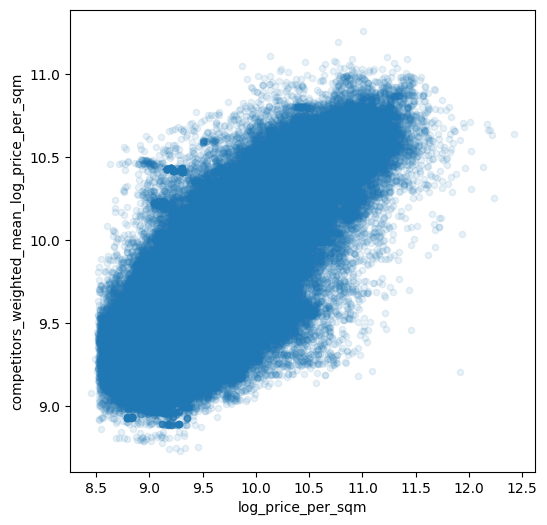

In [33]:
# see relationship between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm
fig, ax = plt.subplots(figsize=(6, 6))

(
    gdf_properties
    .query("num_competitors.ge(4)")
    .plot(
        x='log_price_per_sqm',
        y='competitors_weighted_mean_log_price_per_sqm',
        kind='scatter',
        ax=ax,
        alpha=0.1
    )
)

<Axes: xlabel='log_price_per_sqm', ylabel='competitors_mean_log_price_per_sqm'>

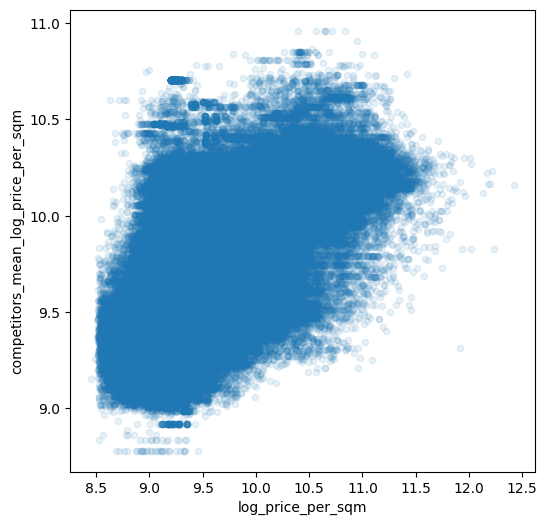

In [34]:
# see relationship between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm
fig, ax = plt.subplots(figsize=(6, 6))

(
    gdf_properties
    .query("num_competitors.ge(4)")
    .plot(
        x='log_price_per_sqm',
        y='competitors_mean_log_price_per_sqm',
        kind='scatter',
        ax=ax,
        alpha=0.1
    )
)

In [35]:
# see corr between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm and competitors_mean_log_price_per_sqm
(
    gdf_properties
    .query("num_competitors.ge(4)")
    .loc[:, ['log_price_per_sqm', 'competitors_weighted_mean_log_price_per_sqm', 'competitors_mean_log_price_per_sqm']]
    .corr(method='spearman')
)

,log_price_per_sqm,competitors_weighted_mean_log_price_per_sqm,competitors_mean_log_price_per_sqm
log_price_per_sqm,1.000000,0.638519,0.510726
competitors_weighted_mean_log_price_per_sqm,0.638519,1.000000,0.846486
competitors_mean_log_price_per_sqm,0.510726,0.846486,1.000000


## S3: Save

In [36]:
# rename
df_competitors_info = df_competitors_info.rename(columns={
    'property_id_own': 'property_id'
})
df_competitors_info.head()

,property_id,competitors_weighted_mean_log_price_per_sqm,competitors_weighted_std_log_price_per_sqm,competitors_mean_log_price_per_sqm,competitors_std_log_price_per_sqm,num_competitors
0,0002b8fe92544e4b8af409bbb9f4a86b,9.358893,0.245959,9.597458,0.454423,51.0
1,00056d55e77146738ff4850e9559e1ce,10.044104,0.448061,9.738157,0.406101,6.0
2,0008a6a2da1d4e3b860ca8b51af5658e,9.383237,0.204100,9.557647,0.355664,17.0
3,0018f6096c7b4595868cf3eb5e6b0341,9.765227,0.475866,9.685282,0.400163,5.0
4,001a550115e540309f4bfabf1291f701,9.651463,0.306589,9.903253,0.522217,16.0


In [37]:
# save
dir_save = "../../data/misc"
os.makedirs(dir_save, exist_ok=True)

# save to parquet
df_competitors_info.to_parquet(f"{dir_save}/df_competitors_stats.parquet")

---
# Save

In [38]:
df_competitors_info.drop(columns='property_id').columns

Index(['competitors_weighted_mean_log_price_per_sqm',
       'competitors_weighted_std_log_price_per_sqm',
       'competitors_mean_log_price_per_sqm',
       'competitors_std_log_price_per_sqm', 'num_competitors'],
      dtype='object')

In [39]:
# drop competitors columns
gdf_properties.drop(columns=df_competitors_info.drop(columns='property_id').columns, inplace=True)

# sort index
gdf_properties = gdf_properties.sort_index()

# save to parquet
gdf_properties.to_parquet("../../data/interim/cleaned_data_s6.parquet")

In [40]:
# stopper
fjasdklf + cdsajofasd

NameError: name 'fjasdklf' is not defined

---
# Get Competitors Blueprint

## S1: Get Neighbors 

In [ ]:
# subset
gdf_properties_work = (
    gdf_properties
    .query("city_cluster.eq(0)")
    .query("property_type.eq('apartment')")
    .copy()
    .reset_index(drop=True)
    )

# see shape
gdf_properties_work.shape

(65429, 53)

In [ ]:
# get neighbors in list
def get_neighbors_properties(gdf, r=1):
    # copy
    gdf = gdf.copy()

    # fit kdtree
    kdtree = KDTree(
        data=gdf[['longitude', 'latitude']],
    )

    # get neighbors at r-km
    return kdtree.query_ball_point(
        gdf[['longitude', 'latitude']],
        r=r * 1_000,
        workers=-1
    )

# get neighbors
gdf_properties_work['neighbors_list'] = get_neighbors_properties(gdf_properties_work, r=1)

In [ ]:
# see neighbors
gdf_properties_work['neighbors_list'].tail(10)

65419    [185, 473, 691, 1919, 3366, 3697, 4775, 4954, ...
65420    [481, 501, 523, 525, 529, 568, 582, 619, 625, ...
65421    [225, 984, 1500, 1539, 1711, 3601, 3951, 4560,...
65422    [271, 273, 275, 283, 299, 300, 301, 302, 303, ...
65423    [271, 273, 275, 299, 300, 301, 302, 303, 304, ...
65424    [271, 273, 275, 299, 300, 301, 302, 303, 304, ...
65425    [271, 273, 275, 299, 300, 301, 302, 303, 304, ...
65426    [271, 273, 275, 299, 300, 301, 302, 303, 304, ...
65427    [271, 273, 275, 299, 300, 301, 302, 303, 304, ...
65428    [271, 273, 275, 299, 300, 301, 302, 303, 304, ...
Name: neighbors_list, dtype: object

In [ ]:
# expand list for last property
cols_to_stay = [
    'property_id',
    # variables to stay
    # geographic
    'longitude', 'latitude',
    # topology
    'superficie_terreno', 'superficie_construida',
    # characteristics
    'elevador_cat', 'niveles_cat', 'vida_util_cat', 
    'recamaras_cat', 'banos_cat', 'estacionamiento_cat',
    # time
    'fecha_avaluo',
]

# get possible neighbors
gdf_neighbors = (
    gdf_properties_work
    .tail(1)  # example
    .loc[:, cols_to_stay + ['neighbors_list']]
    .explode('neighbors_list')
    .rename(columns={'neighbors_list': 'id_neighbor'})
    .query("index != id_neighbor")  # remove self
    .reset_index()
    # join id_neighbor with gdf_properties_work using the index
    .merge(
        (
            gdf_properties_work
            .assign(index=gdf_properties_work.index)
            .loc[:, ['index'] + cols_to_stay]
            ),
        how='left',
        left_on='id_neighbor',
        right_on='index',
        suffixes=('_own', '_neighbor'),

    )
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude_neighbor'], x['latitude_neighbor']),
    )
    .pipe(gpd.GeoDataFrame, crs="EPSG:6372", geometry='geometry')
)
gdf_neighbors.tail()

,index_own,property_id_own,longitude_own,latitude_own,superficie_terreno_own,superficie_construida_own,elevador_cat_own,niveles_cat_own,vida_util_cat_own,recamaras_cat_own,banos_cat_own,estacionamiento_cat_own,fecha_avaluo_own,id_neighbor,index_neighbor,property_id_neighbor,longitude_neighbor,latitude_neighbor,superficie_terreno_neighbor,superficie_construida_neighbor,elevador_cat_neighbor,niveles_cat_neighbor,vida_util_cat_neighbor,recamaras_cat_neighbor,banos_cat_neighbor,estacionamiento_cat_neighbor,fecha_avaluo_neighbor,geometry
882,65428,8e156a1bf23e44a8a97269e4cf48c74e,2.790762e+06,876800.270016,110,52,1,1,2,2,1,1,2022-11-25,65423,65423,410be86651d84891bacb518ca662e527,2.790739e+06,876800.142271,59,50,1,1,2,2,1,1,2022-11-25,POINT (2790739.118 876800.142)
883,65428,8e156a1bf23e44a8a97269e4cf48c74e,2.790762e+06,876800.270016,110,52,1,1,2,2,1,1,2022-11-25,65424,65424,de9ba980457849c3b3ceb685859ac908,2.790704e+06,876797.509628,122,52,1,1,2,2,1,1,2022-11-25,POINT (2790704.134 876797.510)
884,65428,8e156a1bf23e44a8a97269e4cf48c74e,2.790762e+06,876800.270016,110,52,1,1,2,2,1,1,2022-11-25,65425,65425,d122a3ab8aa94dcba737b0848ee9d8a2,2.790762e+06,876800.270016,59,50,1,1,2,2,1,1,2022-11-25,POINT (2790762.166 876800.270)
885,65428,8e156a1bf23e44a8a97269e4cf48c74e,2.790762e+06,876800.270016,110,52,1,1,2,2,1,1,2022-11-25,65426,65426,2371f965e265499e9354109622743ab7,2.790762e+06,876800.270016,62,51,1,1,2,2,1,1,2022-11-25,POINT (2790762.166 876800.270)
886,65428,8e156a1bf23e44a8a97269e4cf48c74e,2.790762e+06,876800.270016,110,52,1,1,2,2,1,1,2022-11-25,65427,65427,23900e6381784faebaf403bdcb4ab525,2.790762e+06,876800.270016,60,52,1,1,2,2,1,1,2022-11-25,POINT (2790762.166 876800.270)


(2789662.166270111, 2791862.166270111, 875700.2700155517, 877900.2700155517)

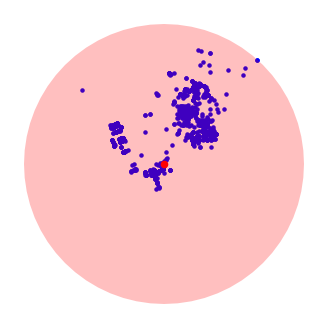

In [ ]:
# plot neighbors
fig, ax = plt.subplots(figsize=(4, 4))

# neighbors
(
    gdf_neighbors
    .loc[:, ['geometry']]
    .plot(
        color='blue', ax=ax, markersize=5
    )
)

# point of interest
(
    gdf_properties_work
    .tail(1)  # example
    .plot(
        color='red', ax=ax, markersize=20
    )
)

# generate a buffer of size 1000m for the last property
(
    gdf_properties_work
    .tail(1)
    .buffer(1_000)
    .plot(ax=ax, color='red', alpha=0.25)
)

# dont show axis
ax.axis('off')

## S2: Distance of Neighbors

### Calculate

In [ ]:
# params
GEO_WEIGHT = 0.1
TERRAIN_WEIGHT = 0.1
BUILT_WEIGHT = 0.35
CHAR_WEIGHT = 0.25
TIME_WEIGHT = 0.2

In [ ]:
# get distance
def get_distance_competitors(gdf):
    # distance
    gdf_distance = (
        gdf.copy()
        .assign(
            # geo distance
            geo_distance=lambda x: np.sqrt(np.sqrt(
                (x['longitude_own'] - x['longitude_neighbor'])**2
                + (x['latitude_own'] - x['latitude_neighbor'])**2
            ) / 1e+3),  # normalize to 0-1
            # topology distance
            terrain_distance=lambda x: np.abs(1-x['superficie_terreno_neighbor'] / x['superficie_terreno_own']).clip(0, 1),
            built_distance=lambda x: np.sqrt(np.abs(1-x['superficie_construida_neighbor'] / x['superficie_construida_own']).clip(0, 1)),
            # characteristics distance
            characteristics_distance=lambda x: np.sqrt(np.sqrt(
                (x['elevador_cat_own'] - x['elevador_cat_neighbor'])**2  # 0s & 1s
                + (x['niveles_cat_own'] - x['niveles_cat_neighbor'])**2  # 1s & 2s (idem)
                + (x['vida_util_cat_own'] - x['vida_util_cat_neighbor'])**2  
                + (x['recamaras_cat_own'] - x['recamaras_cat_neighbor'])**2
                + (x['banos_cat_own'] - x['banos_cat_neighbor'])**2
                + (x['estacionamiento_cat_own'] - x['estacionamiento_cat_neighbor'])**2
            ) / (0.5 * np.sqrt(1 + 1 + 3**2 + 3**2 + 3**2 + 3**2))),
            # time distance (relu)
            time_distance_raw=lambda x: (
               (x['fecha_avaluo_own'] - x['fecha_avaluo_neighbor']).dt.days
            ),
            time_distance=lambda x: np.square(x['time_distance_raw'] * (x['time_distance_raw'] > 0) / 365),  # normalize to 0-1 up to a year
        )
        .query("time_distance.le(1)")  # filter out those that are more than a year apart
        .assign(
            # total distance
            total_distance=lambda x: (
                x['geo_distance'] * GEO_WEIGHT
                + x['terrain_distance'] * TERRAIN_WEIGHT
                + x['built_distance'] * BUILT_WEIGHT
                + x['characteristics_distance'] * CHAR_WEIGHT
                + x['time_distance'] * TIME_WEIGHT
            )
        )
        .sort_values(by='total_distance', ignore_index=True)
    )
    # return important columns
    cols_to_return = [
        'property_id_own', 'property_id_neighbor',
        'total_distance',
        'geo_distance', 'terrain_distance', 'built_distance', 'characteristics_distance', 
        'time_distance'
    ]

    return gdf_distance.loc[:, cols_to_return]

# get distance
gdf_distance_neighbors = get_distance_competitors(gdf_neighbors)
gdf_distance_neighbors

,property_id_own,property_id_neighbor,total_distance,geo_distance,terrain_distance,built_distance,characteristics_distance,time_distance
0,8e156a1bf23e44a8a97269e4cf48c74e,b14d610ef1214a7e80c7e8559e5ddae2,0.032932,0.292955,0.036364,0.000000,0.000000,0.000000
1,8e156a1bf23e44a8a97269e4cf48c74e,715aa95018844cfd9405076fca7348d3,0.034898,0.330796,0.018182,0.000000,0.000000,0.000000
2,8e156a1bf23e44a8a97269e4cf48c74e,de9ba980457849c3b3ceb685859ac908,0.035013,0.241035,0.109091,0.000000,0.000000,0.000000
3,8e156a1bf23e44a8a97269e4cf48c74e,e1ed3631f2ea4cd2ad21c1ffd37a867a,0.045261,0.416248,0.036364,0.000000,0.000000,0.000000
4,8e156a1bf23e44a8a97269e4cf48c74e,23900e6381784faebaf403bdcb4ab525,0.045455,0.000000,0.454545,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
452,8e156a1bf23e44a8a97269e4cf48c74e,3e53434b9b544fb2a81f1cd91c6b8ca2,0.500433,0.571678,0.472727,0.196116,0.569599,0.924759
453,8e156a1bf23e44a8a97269e4cf48c74e,95cb79c9471e4859bbe3f008b10088c0,0.502387,0.633132,0.472727,0.196116,0.569599,0.903802
454,8e156a1bf23e44a8a97269e4cf48c74e,29557c6466d743489e26cd3b580be381,0.509196,0.654285,0.327273,0.196116,0.569599,1.000000
455,8e156a1bf23e44a8a97269e4cf48c74e,56b040a7afbe4e20a69599ad5cb6ca9f,0.510495,0.558181,0.436364,0.196116,0.569599,1.000000


### Validate

In [ ]:
# see if property_id_own is in the neighbors_list
(
    gdf_distance_neighbors
    .query("property_id_own.eq(property_id_neighbor)")
    .shape
)

(0, 8)

In [ ]:
# get top 5 neighbors and see them
ids_top_5 = gdf_distance_neighbors.head(5)['property_id_neighbor'].values

# see values
(
    gdf_neighbors
    .query("property_id_neighbor.isin(@ids_top_5)")
    # sort columns by name
    .sort_index(axis=1)
)
# ids_top_5

,banos_cat_neighbor,banos_cat_own,elevador_cat_neighbor,elevador_cat_own,estacionamiento_cat_neighbor,estacionamiento_cat_own,fecha_avaluo_neighbor,fecha_avaluo_own,geometry,id_neighbor,index_neighbor,index_own,latitude_neighbor,latitude_own,longitude_neighbor,longitude_own,niveles_cat_neighbor,niveles_cat_own,property_id_neighbor,property_id_own,recamaras_cat_neighbor,recamaras_cat_own,superficie_construida_neighbor,superficie_construida_own,superficie_terreno_neighbor,superficie_terreno_own,vida_util_cat_neighbor,vida_util_cat_own
204,1,1,1,1,1,1,2022-12-06,2022-11-25,POINT (2790725.000 876631.041),7421,7421,65428,876631.041067,876800.270016,2.790725e+06,2.790762e+06,1,1,e1ed3631f2ea4cd2ad21c1ffd37a867a,8e156a1bf23e44a8a97269e4cf48c74e,2,2,52,52,114,110,2,2
246,1,1,1,1,1,1,2022-12-15,2022-11-25,POINT (2790687.672 876757.654),7670,7670,65428,876757.653517,876800.270016,2.790688e+06,2.790762e+06,1,1,b14d610ef1214a7e80c7e8559e5ddae2,8e156a1bf23e44a8a97269e4cf48c74e,2,2,52,52,114,110,2,2
760,1,1,1,1,1,1,2023-07-19,2022-11-25,POINT (2790673.152 876736.627),57316,57316,65428,876736.626765,876800.270016,2.790673e+06,2.790762e+06,1,1,715aa95018844cfd9405076fca7348d3,8e156a1bf23e44a8a97269e4cf48c74e,2,2,52,52,108,110,2,2
883,1,1,1,1,1,1,2022-11-25,2022-11-25,POINT (2790704.134 876797.510),65424,65424,65428,876797.509628,876800.270016,2.790704e+06,2.790762e+06,1,1,de9ba980457849c3b3ceb685859ac908,8e156a1bf23e44a8a97269e4cf48c74e,2,2,52,52,122,110,2,2
886,1,1,1,1,1,1,2022-11-25,2022-11-25,POINT (2790762.166 876800.270),65427,65427,65428,876800.270016,876800.270016,2.790762e+06,2.790762e+06,1,1,23900e6381784faebaf403bdcb4ab525,8e156a1bf23e44a8a97269e4cf48c74e,2,2,52,52,60,110,2,2


In [ ]:
# get top 5 neighbors and see them
ids_top_5 = gdf_distance_neighbors.tail(5)['property_id_neighbor'].values

# see values
(
    gdf_neighbors
    .query("property_id_neighbor.isin(@ids_top_5)")
    # sort columns by name
    .sort_index(axis=1)
)
# ids_top_5

,banos_cat_neighbor,banos_cat_own,elevador_cat_neighbor,elevador_cat_own,estacionamiento_cat_neighbor,estacionamiento_cat_own,fecha_avaluo_neighbor,fecha_avaluo_own,geometry,id_neighbor,index_neighbor,index_own,latitude_neighbor,latitude_own,longitude_neighbor,longitude_own,niveles_cat_neighbor,niveles_cat_own,property_id_neighbor,property_id_own,recamaras_cat_neighbor,recamaras_cat_own,superficie_construida_neighbor,superficie_construida_own,superficie_terreno_neighbor,superficie_terreno_own,vida_util_cat_neighbor,vida_util_cat_own
7,1,1,1,1,1,1,2021-11-25,2022-11-25,POINT (2790991.892 877161.500),303,303,65428,877161.499561,876800.270016,2.790992e+06,2.790762e+06,2,1,29557c6466d743489e26cd3b580be381,8e156a1bf23e44a8a97269e4cf48c74e,2,2,50,52,74,110,2,2
119,1,1,1,1,1,1,2021-11-25,2022-11-25,POINT (2790174.975 877328.324),4824,4824,65428,877328.323742,876800.270016,2.790175e+06,2.790762e+06,2,1,0cb41be4d3d74ef0933654bbbfd3fec0,8e156a1bf23e44a8a97269e4cf48c74e,2,2,50,52,74,110,2,2
140,1,1,1,1,1,1,2021-12-09,2022-11-25,POINT (2790942.875 877072.580),4983,4983,65428,877072.580319,876800.270016,2.790943e+06,2.790762e+06,2,1,3e53434b9b544fb2a81f1cd91c6b8ca2,8e156a1bf23e44a8a97269e4cf48c74e,2,2,50,52,58,110,2,2
146,1,1,1,1,1,1,2021-12-13,2022-11-25,POINT (2791032.018 877096.691),4990,4990,65428,877096.691275,876800.270016,2.791032e+06,2.790762e+06,2,1,95cb79c9471e4859bbe3f008b10088c0,8e156a1bf23e44a8a97269e4cf48c74e,2,2,50,52,58,110,2,2
194,1,1,1,1,1,1,2021-11-25,2022-11-25,POINT (2790869.112 877092.906),6462,6462,65428,877092.906426,876800.270016,2.790869e+06,2.790762e+06,2,1,56b040a7afbe4e20a69599ad5cb6ca9f,8e156a1bf23e44a8a97269e4cf48c74e,2,2,50,52,62,110,2,2


<Axes: >

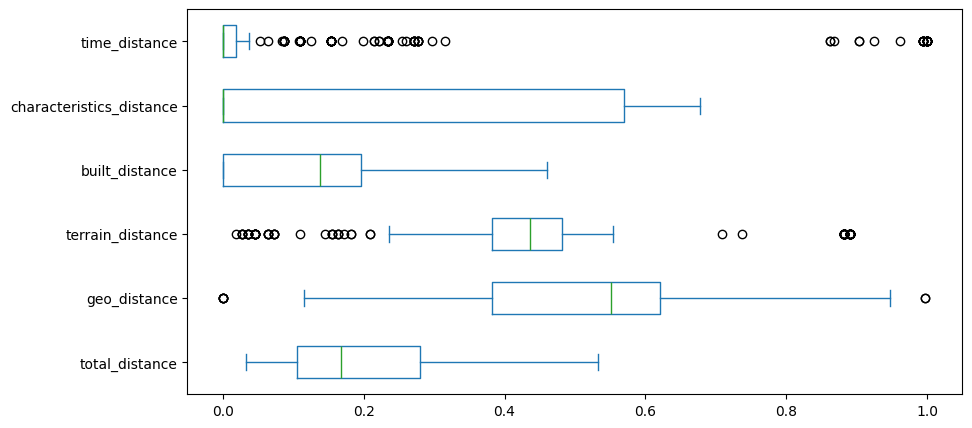

In [ ]:
# see distance distribution
(
    gdf_distance_neighbors
    .filter(like='_distance')
    .plot(kind='box', vert=False, figsize=(10, 5))
)

## S3: Subset of neighbors

In [ ]:
# subset neighbors in 2: index & distance
def subset_neighbors(df):
    return (
        df
        .assign(
            index_distance_tuple=lambda x: list(zip(x['property_id_neighbor'], x['total_distance'])),
        )
        .groupby('property_id_own', as_index=False)
        .agg(
            neighbors_list=('index_distance_tuple', list),
        )
    )

# subset
gdf_neighbors_subset = subset_neighbors(gdf_distance_neighbors)
gdf_neighbors_subset

,property_id_own,neighbors_list
0,8e156a1bf23e44a8a97269e4cf48c74e,"[(b14d610ef1214a7e80c7e8559e5ddae2, 0.03293184..."


In [ ]:
# explode and separate
(
    gdf_neighbors_subset
    .explode('neighbors_list')
    .assign(
        property_id_neighbor=lambda x: x['neighbors_list'].str[0],
        total_distance=lambda x: x['neighbors_list'].str[1],
    )
    .drop(columns=['neighbors_list'])
    .sort_values(by='total_distance', ignore_index=True)
)

,property_id_own,property_id_neighbor,total_distance
0,8e156a1bf23e44a8a97269e4cf48c74e,b14d610ef1214a7e80c7e8559e5ddae2,0.032932
1,8e156a1bf23e44a8a97269e4cf48c74e,715aa95018844cfd9405076fca7348d3,0.034898
2,8e156a1bf23e44a8a97269e4cf48c74e,de9ba980457849c3b3ceb685859ac908,0.035013
3,8e156a1bf23e44a8a97269e4cf48c74e,e1ed3631f2ea4cd2ad21c1ffd37a867a,0.045261
4,8e156a1bf23e44a8a97269e4cf48c74e,23900e6381784faebaf403bdcb4ab525,0.045455
...,...,...,...
452,8e156a1bf23e44a8a97269e4cf48c74e,3e53434b9b544fb2a81f1cd91c6b8ca2,0.500433
453,8e156a1bf23e44a8a97269e4cf48c74e,95cb79c9471e4859bbe3f008b10088c0,0.502387
454,8e156a1bf23e44a8a97269e4cf48c74e,29557c6466d743489e26cd3b580be381,0.509196
455,8e156a1bf23e44a8a97269e4cf48c74e,56b040a7afbe4e20a69599ad5cb6ca9f,0.510495


---
# Sandbox

In [ ]:
(gdf_neighbors['fecha_avaluo_own'] - gdf_neighbors['fecha_avaluo_neighbor']).dt.days

0      423
1      641
2      403
3      515
4      372
      ... 
882      0
883      0
884      0
885      0
886      0
Length: 887, dtype: int64

In [ ]:
gdf_neighbors.columns

Index(['index_own', 'property_id_own', 'longitude_own', 'latitude_own',
       'superficie_terreno_own', 'superficie_construida_own',
       'elevador_cat_own', 'niveles_cat_own', 'vida_util_cat_own',
       'recamaras_cat_own', 'banos_cat_own', 'estacionamiento_cat_own',
       'fecha_avaluo_own', 'id_neighbor', 'index_neighbor',
       'property_id_neighbor', 'longitude_neighbor', 'latitude_neighbor',
       'superficie_terreno_neighbor', 'superficie_construida_neighbor',
       'elevador_cat_neighbor', 'niveles_cat_neighbor',
       'vida_util_cat_neighbor', 'recamaras_cat_neighbor',
       'banos_cat_neighbor', 'estacionamiento_cat_neighbor',
       'fecha_avaluo_neighbor', 'geometry'],
      dtype='object')

In [ ]:
# join with df_competitors
(
    df_competitors
    .merge(
        df_properties_map,
        how='inner',
        left_on='property_id_own',
        right_on='property_id',
        suffixes=('_comp', '_map')
    )
)

,property_id_own,neighbors_list,num_neighbors,property_index,property_id
0,0003628769da4852a1cbb95a63c1e9fa,"[(8067a5e4b2bb48338ef957f37f24d9c0, 0.78304554...",6,15571,0003628769da4852a1cbb95a63c1e9fa
1,003b63fc3d0740fb8ccf08850c0e8d47,"[(623abf59e5a4483ab3d47d32c4c40ec6, 0.47014149...",3,55078,003b63fc3d0740fb8ccf08850c0e8d47
2,0071eb18431740f3851a5ffc9ea4769f,"[(ba5d42cb2a9244e3931ffbcc94f413b8, 0.93270803...",7,95674,0071eb18431740f3851a5ffc9ea4769f
3,00ac740c94484fe292960af6fa9ce2a4,"[(ba5d42cb2a9244e3931ffbcc94f413b8, 0.51934652...",2,93416,00ac740c94484fe292960af6fa9ce2a4
4,00b3256315ae463c93b909511ce9a2c5,"[(1cd8c3f2aeb24183b925f4882c983c3e, 1.03949739...",21,27675,00b3256315ae463c93b909511ce9a2c5
...,...,...,...,...,...
31960,fc14b08491dc4c93b8d0b322ca7a5359,"[(90b235057cb649b6b995e544daf6b219, 0.95424442...",1,31032,fc14b08491dc4c93b8d0b322ca7a5359
31961,fc870f84ca7e40789082fde993877334,"[(472b64d6b1834e2e935fc38834b60b11, 0.74121243...",2,540292,fc870f84ca7e40789082fde993877334
31962,fe7634d89acc4eb5a43bd720d8f449f1,"[(472b64d6b1834e2e935fc38834b60b11, 0.78562675...",2,274512,fe7634d89acc4eb5a43bd720d8f449f1
31963,ff1dc57a1d2c4e1794a189a277ceb4a8,"[(472b64d6b1834e2e935fc38834b60b11, 0.93559195...",2,30346,ff1dc57a1d2c4e1794a189a277ceb4a8


In [ ]:
df_competitors

,property_id_own,neighbors_list,num_neighbors
0,0003628769da4852a1cbb95a63c1e9fa,"[(8067a5e4b2bb48338ef957f37f24d9c0, 0.78304554...",6
1,003b63fc3d0740fb8ccf08850c0e8d47,"[(623abf59e5a4483ab3d47d32c4c40ec6, 0.47014149...",3
2,0071eb18431740f3851a5ffc9ea4769f,"[(ba5d42cb2a9244e3931ffbcc94f413b8, 0.93270803...",7
3,00ac740c94484fe292960af6fa9ce2a4,"[(ba5d42cb2a9244e3931ffbcc94f413b8, 0.51934652...",2
4,00b3256315ae463c93b909511ce9a2c5,"[(1cd8c3f2aeb24183b925f4882c983c3e, 1.03949739...",21
...,...,...,...
31960,fc14b08491dc4c93b8d0b322ca7a5359,"[(90b235057cb649b6b995e544daf6b219, 0.95424442...",1
31961,fc870f84ca7e40789082fde993877334,"[(472b64d6b1834e2e935fc38834b60b11, 0.74121243...",2
31962,fe7634d89acc4eb5a43bd720d8f449f1,"[(472b64d6b1834e2e935fc38834b60b11, 0.78562675...",2
31963,ff1dc57a1d2c4e1794a189a277ceb4a8,"[(472b64d6b1834e2e935fc38834b60b11, 0.93559195...",2


In [ ]:
gdf_properties.shape

(852913, 53)

In [ ]:
np.square(3)

9

In [ ]:
gdf_properties_work['property_id']

0         66cf10199ef943a5a5ff82129e53d5d7
1         f84f9a0c784f491eab6bb100b513a95b
2         7ddd5a94feed4955a809f986d95722d8
3         d2e75fb3b385461995bf8d34b9d1fdfb
4         6f1194f9853443219e63f4a3222b010e
                        ...               
118675    3ce971986e8d40d289761daaa16e8b07
118676    4fca7e24dc0747d393f16787dec9ba4d
118677    92ae0c15323345beb3d8704ffac10122
118678    75407e02946c4eef93fd3030f0c802cf
118679    8606510ad224492f898bcd2c9c07295a
Name: property_id, Length: 118680, dtype: object

In [ ]:
(1.96)**2

3.8415999999999997

In [ ]:
np.array_split(np.arange(10), 4)

[array([0, 1, 2]), array([3, 4, 5]), array([6, 7]), array([8, 9])]

In [ ]:
aux_list = []

# append
aux_list.append(2)

aux_list

[2,
 Empty DataFrame
 Columns: []
 Index: []]

In [ ]:
gdf_properties.columns

Index(['property_id', 'valor_fisico_construccion', 'id_avaluo', 'fecha_avaluo',
       'colonia', 'id_clase_inmueble', 'id_tipo_inmueble', 'conservacion',
       'elevador', 'niveles', 'cve_ref_proximidad_urbana',
       'cve_nivel_equipamiento_urbano', 'valor_mercado',
       'valor_concluido_total', 'nivel', 'unidades_rentables', 'edad_anios',
       'precio_m2', 'vida_util_remanente', 'cve_clasificacion_zona',
       'cve_vigilancia', 'regimen_propiedad', 'tipo_vialidad', 'id_uv',
       'id_municipio', 'id_entidad_f', 'clave_controlador', 'clave_valuador',
       'id_otorgante', 'cp', 'latitud', 'longitud', 'recamaras', 'banos',
       'medio_banos', 'estacionamiento', 'superficie_terreno',
       'superficie_construida', 'superficie_accesoria', 'superficie_vendible',
       'valor_fisico_terreno_m2', 'geometry', 'property_type', 'longitude',
       'latitude', 'recamaras_cat', 'banos_cat', 'niveles_cat',
       'vida_util_cat', 'elevador_cat', 'estacionamiento_cat', 'city_cluster'

In [ ]:
?np.array_split

Signature:       np.array_split(ary, indices_or_sections, axis=0)
Call signature:  np.array_split(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function array_split at 0x7f9cb0b2bac0>
File:            ~/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/numpy/lib/shape_base.py
Docstring:      
Split an array into multiple sub-arrays.

Please refer to the ``split`` documentation.  The only difference
between these functions is that ``array_split`` allows
`indices_or_sections` to be an integer that does *not* equally
divide the axis. For an array of length l that should be split
into n sections, it returns l % n sub-arrays of size l//n + 1
and the rest of size l//n.

See Also
--------
split : Split array into multiple sub-arrays of equal size.

Examples
--------
>>> x = np.arange(8.0)
>>> np.array_split(x, 3)
[array([0.,  1.,  2.]), array([3.,  4.,  5.]), array([6.,  7.])]

>>> x = np.arange(9)
>>> np.array_split(x, 4)
[array([0, 1, 2]), arra